Neste notebook, veremos um exemplo simples de como criar uma rede neural usando o Pytorch.

In [ ]:
# Importa o PyTorch, que é uma biblioteca poderosa para construir e treinar redes neurais
import torch

# Importa ferramentas da biblioteca torchvision, que facilita o acesso a conjuntos de dados de imagens
# e também oferece transformações úteis para pré-processar essas imagens
from torchvision import datasets, transforms

# Importa utilitários do PyTorch que ajudam a organizar e carregar os dados em mini-lotes (batches)
from torch.utils.data import DataLoader, Subset

# Importa a biblioteca NumPy, muito usada para lidar com arrays e fazer cálculos numéricos
import numpy as np

# Importa os módulos necessários para construir redes neurais no PyTorch:
# - nn contém os blocos de construção das redes, como camadas lineares, convolucionais, etc.
import torch.nn as nn

# - nn.functional contém funções úteis como funções de ativação (ReLU, softmax, etc.) e outras operações
import torch.nn.functional as F

# Importa o matplotlib para exibir gráficos e imagens, útil para visualizar os dados e os resultados
import matplotlib.pyplot as plt

# Módulo de otimização do PyTorch (como o otimizador Adam)
import torch.optim as optim

In [ ]:
def load_mnist_filtered(train_size, test_size, batch_size):
    """
    Função que carrega o conjunto de dados MNIST, mas apenas com os dígitos 0, 1 e 2.
    As imagens são achatadas (flattened) em vetores de 784 posições (28x28 pixels viram uma linha com 784 números).

    Parâmetros:
    - train_size (int): número de imagens que queremos usar para treinar a rede
    - test_size (int): número de imagens que queremos usar para testar a rede
    - batch_size (int): quantas imagens serão passadas por vez para a rede durante o treinamento (isso é chamado de "batch")

    Retorna:
    - train_loader: objeto que permite carregar os dados de treinamento em mini-lotes
    - test_loader: objeto que permite carregar os dados de teste em mini-lotes
    """

    # Aqui criamos uma transformação que será aplicada a cada imagem do MNIST.
    # 1. ToTensor() transforma a imagem em um tensor (estrutura usada pelo PyTorch).
    # 2. Lambda achata a imagem de 28x28 para um vetor de tamanho 784 (28*28 = 784).
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))  # Achata a imagem: de 1x28x28 para (784,)
    ])

    # Baixamos o conjunto de dados MNIST, tanto de treino quanto de teste.
    # Os dados são automaticamente transformados com o que definimos acima.
    full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    full_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Essa função filtra apenas as imagens que representam os dígitos 0, 1 e 2
    def filter_digits(dataset):
        # Cria uma lista de índices onde os rótulos (targets) são 0, 1 ou 2
        indices = np.where(np.isin(dataset.targets, [0, 1, 2]))[0]
        # Usa apenas os dados com esses índices
        return Subset(dataset, indices)

    # Aplica o filtro nos conjuntos de treino e teste
    filtered_train = filter_digits(full_train_dataset)
    filtered_test = filter_digits(full_test_dataset)

    # Essa função pega aleatoriamente 'size' exemplos do conjunto filtrado
    def get_subset(subset, size):
        # Gera uma permutação aleatória dos índices e seleciona os 'size' primeiros
        indices = torch.randperm(len(subset))[:size]
        # Retorna apenas os exemplos selecionados
        return Subset(subset, indices)

    # Criamos conjuntos menores de treino e teste com a quantidade de exemplos que foi passada
    small_train_dataset = get_subset(filtered_train, train_size)
    small_test_dataset = get_subset(filtered_test, test_size)

    # Agora criamos os "DataLoaders", que vão nos ajudar a carregar os dados em mini-lotes (batches)
    # Durante o treino usamos shuffle=True para embaralhar os dados, o que ajuda no aprendizado
    train_loader = DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(small_test_dataset, batch_size=batch_size, shuffle=False)

    # Retornamos os dois carregadores de dados
    return train_loader, test_loader


In [ ]:
# Aqui estamos criando uma classe chamada SimpleNet, que representa a nossa rede neural.
# Ela herda de nn.Module, que é a base para todos os modelos do PyTorch.
class SimpleNet(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, num_classes=3):
        # Chamamos o construtor da classe-pai (nn.Module) para configurar a base do modelo
        super(SimpleNet, self).__init__()

        # Definimos a primeira camada totalmente conectada (Linear).
        # Ela recebe um vetor de entrada com 784 valores (uma imagem 28x28 achatada) e transforma em 128 valores.
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Segunda camada, também totalmente conectada.
        # Ela recebe os 128 valores da camada anterior e produz 3 saídas (uma para cada classe: dígito 0, 1 ou 2).
        self.fc2 = nn.Linear(hidden_size, num_classes)

    # A função forward define como a entrada passa pelas camadas da rede.
    def forward(self, x):
        # Primeiro, passamos a entrada pela primeira camada e aplicamos a função de ativação ReLU.
        # A ReLU (Rectified Linear Unit) ajuda a rede a aprender relações não lineares entre os dados.
        x = F.relu(self.fc1(x))

        # Depois, passamos pela segunda camada, que gera a saída final da rede (os "logits").
        # Essa saída ainda não é uma probabilidade — ela será usada diretamente com a função de perda.
        x = self.fc2(x)

        # Retornamos a saída final (logits)
        return x


In [ ]:
# Esta função treina o modelo em um conjunto de dados por várias épocas (repetições sobre o conjunto de treino).
def train_model(model, train_loader, test_loader, num_epochs=10, device='cpu'):
    # Move o modelo para o dispositivo escolhido (CPU ou GPU, se disponível)
    model = model.to(device)

    # Define a função de perda (ou função de custo).
    # CrossEntropyLoss é comum em problemas de classificação multiclasse.
    criterion = nn.CrossEntropyLoss()

    # Define o otimizador, que atualiza os pesos da rede.
    # Aqui usamos o Adam, que é um dos otimizadores mais usados atualmente.
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Listas para armazenar a evolução do loss e da acurácia
    train_losses = []
    test_accuracies = []

    # Loop principal de treinamento, onde a rede aprende
    for epoch in range(num_epochs):
        model.train()  # Coloca o modelo em modo de treinamento (ativa dropout, batchnorm, etc.)
        total_loss = 0
        correct = 0
        total = 0

        # Percorre os dados de treino em mini-lotes
        for images, labels in train_loader:
            # Move os dados para o mesmo dispositivo da rede
            images, labels = images.to(device), labels.to(device)

            # Zera os gradientes antigos antes de calcular novos
            optimizer.zero_grad()

            # Passa as imagens pela rede para obter a previsão (logits)
            outputs = model(images)

            # Calcula o custo entre a saída da rede e os rótulos corretos
            loss = criterion(outputs, labels)

            # Calcula os gradientes (backpropagation)
            loss.backward()

            # Atualiza os pesos da rede com base nos gradientes calculados
            optimizer.step()

            # Soma o custo desse mini-lote ao total
            total_loss += loss.item()

            # Calcula o número de acertos
            _, predicted = outputs.max(1)  # Pega o índice da classe com maior valor (logit)
            total += labels.size(0)       # Total de exemplos vistos até agora
            correct += predicted.eq(labels).sum().item()  # Quantos estavam corretos

        # Calcula a média da perda na época
        avg_loss = total_loss / len(train_loader)

        # Calcula a acurácia de treino na época
        train_acc = 100. * correct / total

        # Armazena o loss e a acurácia para visualizar depois
        train_losses.append(avg_loss)

        # Avalia a rede nos dados de teste (sem ajustar os pesos)
        test_acc = evaluate_model(model, test_loader, device)
        test_accuracies.append(test_acc)

        # Mostra o desempenho da época atual
        print(f"Época [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Acurácia Treino: {train_acc:.2f}%, Acurácia Teste: {test_acc:.2f}%")

    # Mostra gráficos com os resultados
    plot_metrics(train_losses, test_accuracies)


# Esta função avalia o desempenho da rede no conjunto de teste
def evaluate_model(model, test_loader, device='cpu'):
    model.eval()  # Coloca o modelo em modo de avaliação (desativa dropout, etc.)
    correct = 0
    total = 0

    # Evita calcular gradientes, o que economiza memória e acelera a execução
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Passa as imagens pela rede
            outputs = model(images)

            # Obtém a classe com maior valor predito
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Retorna a acurácia em porcentagem
    acc = 100. * correct / total
    return acc


# Esta função exibe dois gráficos: um da função de custo e outro da acurácia
def plot_metrics(train_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))  # Cria uma figura com duas áreas de gráfico

    # Gráfico da função de custo (loss)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o', label='Loss Treino')
    plt.title("Função de Custo (Loss) por Época")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Gráfico da acurácia no teste
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, marker='o', color='green', label='Acurácia Teste')
    plt.title("Acurácia no Teste por Época")
    plt.xlabel("Época")
    plt.ylabel("Acurácia (%)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()  # Ajusta os gráficos para não se sobreporem
    plt.show()


In [ ]:
# Função auxiliar para contar quantos parâmetros treináveis existem em um modelo do PyTorch
def contar_parametros(modelo: nn.Module) -> int:
    """
    Retorna o número total de parâmetros treináveis de um modelo PyTorch.

    Parâmetros:
    modelo (nn.Module): O modelo de rede neural construído com PyTorch.

    Retorno:
    int: Número de parâmetros treináveis.
    """

    # Percorre todos os parâmetros do modelo e soma a quantidade total de elementos (números) que serão treinados
    # A verificação "if p.requires_grad" garante que só conta os parâmetros que realmente são otimizáveis (ou seja, que serão atualizados pelo otimizador)
    return sum(p.numel() for p in modelo.parameters() if p.requires_grad)


Época [1/40], Loss: 0.2776, Acurácia Treino: 93.83%, Acurácia Teste: 98.30%
Época [2/40], Loss: 0.0661, Acurácia Treino: 97.97%, Acurácia Teste: 98.90%
Época [3/40], Loss: 0.0431, Acurácia Treino: 98.80%, Acurácia Teste: 98.60%
Época [4/40], Loss: 0.0321, Acurácia Treino: 99.00%, Acurácia Teste: 98.40%
Época [5/40], Loss: 0.0244, Acurácia Treino: 99.43%, Acurácia Teste: 98.40%
Época [6/40], Loss: 0.0187, Acurácia Treino: 99.43%, Acurácia Teste: 98.40%
Época [7/40], Loss: 0.0137, Acurácia Treino: 99.73%, Acurácia Teste: 98.50%
Época [8/40], Loss: 0.0115, Acurácia Treino: 99.80%, Acurácia Teste: 98.50%
Época [9/40], Loss: 0.0094, Acurácia Treino: 99.80%, Acurácia Teste: 98.60%
Época [10/40], Loss: 0.0064, Acurácia Treino: 99.93%, Acurácia Teste: 98.80%
Época [11/40], Loss: 0.0052, Acurácia Treino: 100.00%, Acurácia Teste: 98.50%
Época [12/40], Loss: 0.0039, Acurácia Treino: 100.00%, Acurácia Teste: 98.60%
Época [13/40], Loss: 0.0031, Acurácia Treino: 100.00%, Acurácia Teste: 98.60%
Época

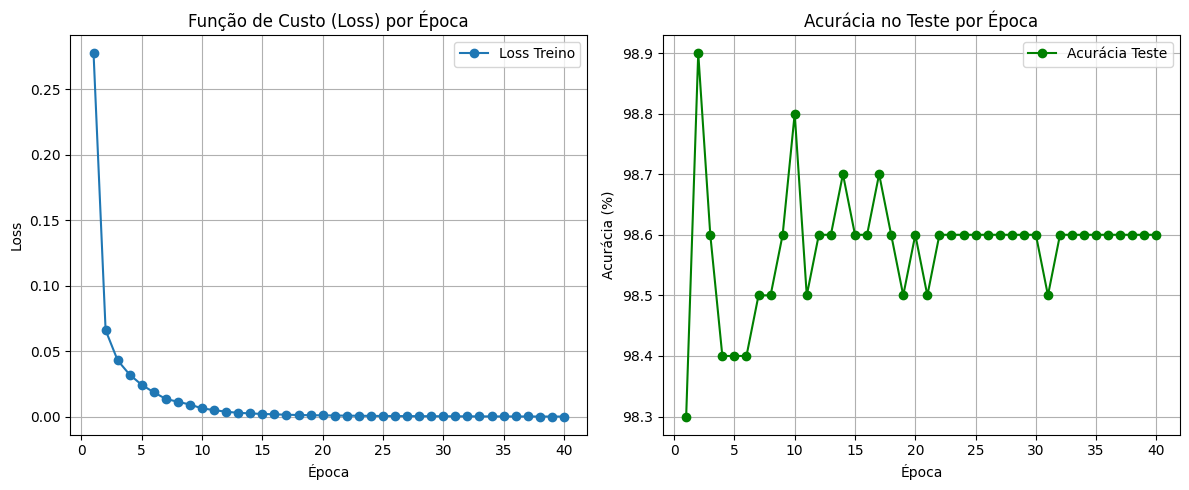

In [ ]:
# Carrega os dados do MNIST, mas apenas os dígitos 0, 1 e 2.
# Vai pegar 3000 imagens para treino, 1000 para teste, divididas em lotes (batches) de 64 imagens.
train_loader, test_loader = load_mnist_filtered(train_size=3000, test_size=1000, batch_size=64)

# Cria uma instância da rede neural definida anteriormente (SimpleNet).
model = SimpleNet()

# Imprime o número total de parâmetros treináveis do modelo (útil para entender a complexidade do modelo)
print('Número de parâmetros no modelo: {}'.format(contar_parametros(model)))


# Treina o modelo por 10 épocas. Se houver uma GPU disponível (via CUDA), ela será usada automaticamente.
# Caso contrário, o treinamento será feito na CPU (mais lento, mas funciona).
train_model(
    model,
    train_loader,
    test_loader,
    num_epochs=40,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
